## Importing the data

In [1]:
import pandas as pd
from itertools import combinations

In [2]:
data = pd.read_csv("../Main Study (Face)/main_study_face_data.csv")

## Pre-processing the data

Renaming the columns to make their meanings clearer:

In [3]:
data.columns = ["participant_id", "trial_number", "pre_post_prime", "chose_masc", "image", "prime_condition"]

Removing the faces subdirectory from the string:

In [4]:
data["image"] = data["image"].str[6:]

Converting the numerical prime conditions to the actual named condition, for clarity:

In [5]:
data["prime_condition_names"] = data["prime_condition"].map({1:"neutral",
                                                             2:"male/male",
                                                             3:"male group",
                                                             4:"male/female",
                                                             5:"pathogen"})                                   

Re-ordering the columns to organise them better:

In [6]:
data = data[["participant_id", "prime_condition", "prime_condition_names", "trial_number", "image", "pre_post_prime", "chose_masc"]]

In [7]:
data

,participant_id,prime_condition,prime_condition_names,trial_number,image,pre_post_prime,chose_masc
0,11,1,neutral,2,Slide11.bmp,0,0
1,11,1,neutral,3,Slide9.bmp,0,1
2,11,1,neutral,4,Slide5.bmp,0,0
3,11,1,neutral,5,Slide1.bmp,0,1
4,11,1,neutral,6,Slide18.bmp,0,1
...,...,...,...,...,...,...,...
12659,75b,5,pathogen,36,Slide20.bmp,1,1
12660,75b,5,pathogen,37,Slide2.bmp,1,1
12661,75b,5,pathogen,38,Slide10.bmp,1,1
12662,75b,5,pathogen,39,Slide14.bmp,1,0


## Exploring the data

### Overview

There are no cells with missing data.

In [8]:
data.isna().sum()

participant_id           0
prime_condition          0
prime_condition_names    0
trial_number             0
image                    0
pre_post_prime           0
chose_masc               0
dtype: int64

looking at the contents of each variable - is there anything unexpected? The contents of all of the variables seems reasonable.

In [9]:
data.apply(lambda x: x.unique())

participant_id           [11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 2...
prime_condition                                            [1, 2, 3, 4, 5]
prime_condition_names    [neutral, male/male, male group, male/female, ...
trial_number             [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...
image                    [Slide11.bmp, Slide9.bmp, Slide5.bmp, Slide1.b...
pre_post_prime                                                      [0, 1]
chose_masc                                                          [0, 1]
dtype: object

There are 331 participants, who each should have taken part in 40 trials, where they were shown the same 20 images, both before and after being exposed to one of the 5 priming conditions.

In [10]:
data.apply(lambda x: x.nunique())
# number of unique values

participant_id           331
prime_condition            5
prime_condition_names      5
trial_number              40
image                     20
pre_post_prime             2
chose_masc                 2
dtype: int64

Roughly the same number of participants were assigned to each of the priming conditions.

In [11]:
data.groupby("prime_condition")["participant_id"].nunique()

prime_condition
1    68
2    67
3    64
4    68
5    64
Name: participant_id, dtype: int64

### Images

Some of the images in particular tended to have a very high percetnage of people preferring the masculine side. Other slides had a strong preference to the feminine side (regardless/aggregating over all of the priming conditions). This very high amount of variation could have been influential.

In [12]:
(data.groupby("image")["chose_masc"].sum() / data.groupby("image")["chose_masc"].count() * 100).sort_values(ascending=False)

image
Slide9.bmp     82.198142
Slide5.bmp     77.637795
Slide15.bmp    72.089314
Slide7.bmp     70.216049
Slide12.bmp    66.406250
Slide18.bmp    63.751987
Slide4.bmp     62.852665
Slide14.bmp    62.439807
Slide6.bmp     59.345794
Slide2.bmp     56.210191
Slide20.bmp    56.045752
Slide17.bmp    50.078003
Slide8.bmp     48.678072
Slide1.bmp     48.330684
Slide16.bmp    46.570973
Slide3.bmp     44.051447
Slide13.bmp    40.873635
Slide11.bmp    37.242472
Slide19.bmp    33.279743
Slide10.bmp    30.625000
Name: chose_masc, dtype: float64

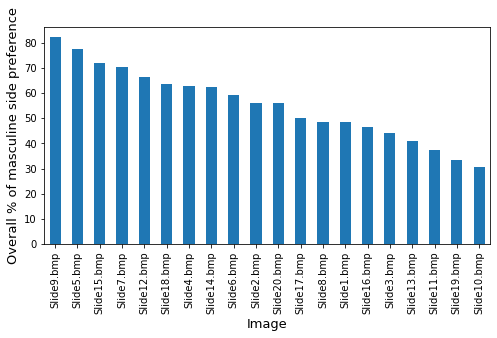

In [13]:
ax = (data.groupby("image")["chose_masc"].sum() / data.groupby("image")["chose_masc"].count() * 100).sort_values(ascending=False).plot.bar(figsize=(8, 4))
ax.set_xlabel("Image", size=13)
ax.set_ylabel("Overall % of masculine side preference", size=13);

Were all of the participants shown all of the images? Each participant should have been shown 20 images. 16 participants were only shown 19 images, not all 20.

In [14]:
num_images_shown = data.groupby("participant_id")["image"].nunique()
num_images_shown[num_images_shown < 20]

participant_id
123    19
130    19
138    19
14     19
155    19
162    19
183    19
245    19
274    19
30     19
42     19
45     19
48     19
61     19
83     19
88     19
Name: image, dtype: int64

Only looking at the participants who were shown <20 images:

In [15]:
participants_with_19_images = data[data["participant_id"].isin(list(num_images_shown[num_images_shown < 20].index))]

Different participants missed seeing different images:

In [16]:
all_images = set(data["image"].unique())
for participant_id, images in zip(list(participants_with_19_images.groupby("participant_id")["image"].unique().index),
                                  participants_with_19_images.groupby("participant_id")["image"].unique()):
    print(participant_id, "has missing image:", all_images - set(images))

123 has missing image: {'Slide20.bmp'}
130 has missing image: {'Slide19.bmp'}
138 has missing image: {'Slide15.bmp'}
14 has missing image: {'Slide17.bmp'}
155 has missing image: {'Slide20.bmp'}
162 has missing image: {'Slide9.bmp'}
183 has missing image: {'Slide18.bmp'}
245 has missing image: {'Slide9.bmp'}
274 has missing image: {'Slide2.bmp'}
30 has missing image: {'Slide1.bmp'}
42 has missing image: {'Slide19.bmp'}
45 has missing image: {'Slide2.bmp'}
48 has missing image: {'Slide14.bmp'}
61 has missing image: {'Slide1.bmp'}
83 has missing image: {'Slide10.bmp'}
88 has missing image: {'Slide15.bmp'}


### Trials

Looking at the number of trials each participant took part in; many participants did not take place in all of the trials!

In [17]:
num_trials_completed = data.groupby("participant_id")["trial_number"].nunique()
num_trials_completed[num_trials_completed < 40]

participant_id
100     35
100b    35
102     39
103     39
105     39
        ..
92      36
93      39
96      37
98      37
99      38
Name: trial_number, Length: 253, dtype: int64

Only 78 participants completed all 40 trials, 253 participants did not.

In [18]:
num_trials_completed.value_counts().sort_index(ascending=False)

40     78
39    109
38     61
37     43
36     19
35      8
34      1
33      8
31      2
30      2
Name: trial_number, dtype: int64

Which different trials are the participants missing?

In [19]:
participants_with_less_images = data[data["participant_id"].isin(list(num_trials_completed[num_trials_completed < 40].index))]
all_trials = set(data["trial_number"].unique())
all_missing_trials = []
for participant_id, trials in zip(list(participants_with_less_images.groupby("participant_id")["trial_number"].unique().index),
                                  participants_with_less_images.groupby("participant_id")["trial_number"].unique()):
    print(participant_id, "has missing trial(s):", all_trials-set(trials))
    for trial in all_trials-set(trials):
        all_missing_trials.append(trial)

100 has missing trial(s): {6, 39, 7, 19, 21}
100b has missing trial(s): {6, 39, 7, 19, 21}
102 has missing trial(s): {1}
103 has missing trial(s): {34}
105 has missing trial(s): {29}
107 has missing trial(s): {4}
108 has missing trial(s): {1, 4}
11 has missing trial(s): {1}
110 has missing trial(s): {1}
111 has missing trial(s): {1, 3, 4, 18, 29}
112 has missing trial(s): {1, 4, 17}
114 has missing trial(s): {7}
115 has missing trial(s): {1, 5}
118 has missing trial(s): {9, 37, 6}
11b has missing trial(s): {1}
12 has missing trial(s): {1}
123 has missing trial(s): {32, 12, 22}
124 has missing trial(s): {1, 3, 5, 11, 16, 17, 23, 28, 29, 31}
125 has missing trial(s): {29}
127 has missing trial(s): {34}
128 has missing trial(s): {1}
129 has missing trial(s): {16, 1}
13 has missing trial(s): {1}
130 has missing trial(s): {26, 19, 22, 39}
131 has missing trial(s): {25, 26}
132 has missing trial(s): {38}
134 has missing trial(s): {15}
137 has missing trial(s): {18, 27, 12}
138 has missing tr

Trials 1-20 occurred before priming, 21-40 occurred after priming. Thus we can see that participants are missing a mix of trials before and after priming.

In [20]:
data[data["trial_number"].isin(list(range(1, 21)))]["pre_post_prime"].unique()

array([0], dtype=int64)

In [21]:
data[data["trial_number"].isin(list(range(21, 40)))]["pre_post_prime"].unique()

array([1], dtype=int64)

Exploring one example with a higher number of missing trials, participant 124:

In [22]:
data[data["participant_id"]=="124"]

,participant_id,prime_condition,prime_condition_names,trial_number,image,pre_post_prime,chose_masc
4233,124,4,male/female,2,Slide7.bmp,0,1
4234,124,4,male/female,4,Slide2.bmp,0,1
4235,124,4,male/female,6,Slide1.bmp,0,0
4236,124,4,male/female,7,Slide20.bmp,0,0
4237,124,4,male/female,8,Slide12.bmp,0,1
4238,124,4,male/female,9,Slide4.bmp,0,1
4239,124,4,male/female,10,Slide10.bmp,0,0
4240,124,4,male/female,12,Slide13.bmp,0,0
4241,124,4,male/female,13,Slide8.bmp,0,0
4242,124,4,male/female,14,Slide16.bmp,0,0


In [23]:
data[data["participant_id"]=="124"]["pre_post_prime"].value_counts()

1    16
0    14
Name: pre_post_prime, dtype: int64

In both the specific example and in general case, there are more trial responses post prime (1) than pre prime (0).

In [24]:
data["pre_post_prime"].value_counts()

1    6447
0    6217
Name: pre_post_prime, dtype: int64

The trials are likely missing because there was a timer on the responses. This also explains why more trials are missing pre-prime, as participants were newer/less confident to the study.  
Trial 1 is missed a lot - this makes sense, as it was the first trial in the study. There is also a spike at trial 21 - because this marks the start of the next set of trials after priming

Text(0, 0.5, 'Number of missed trials')

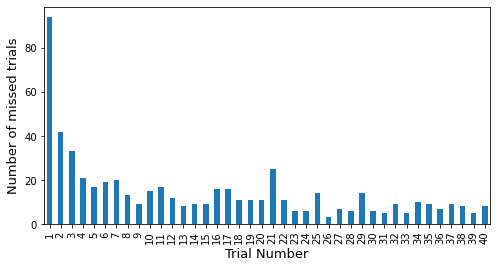

In [25]:
# a bar chart with the missing trial number on the x axis, and frequency of being omitted on the y axis
ax = pd.Series(all_missing_trials).value_counts().sort_index().plot.bar(figsize=(8, 4))
ax.set_xlabel("Trial Number", size=13)
ax.set_ylabel("Number of missed trials", size=13)

### Duplicates

Looking at each unique participant. What do the "b" participants mean? Does the "b" have any significance?

In [26]:
data["participant_id"].unique()

array(['11', '12', '13', '14', '15', '16', '17', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
       '45', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
       '57', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68',
       '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79',
       '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90',
       '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101',
       '102', '103', '104', '105', '106', '107', '108', '109', '110',
       '111', '112', '113', '114', '115', '116', '117', '118', '119',
       '120', '121', '122', '123', '124', '125', '126', '127', '128',
       '129', '130', '131', '132', '133', '134', '135', '136', '137',
       '138', '139', '140', '141', '142', '143', '144', '145', '146',
       '147', '148', '149', '150', '151', '152', '153', '154', '

Creating a list of all the participants with "b" in their name, and "no b" in their name, but the same number:

In [27]:
all_b_participants = [p_id for p_id in list(data["participant_id"].unique()) if "b" in p_id]
b_participants_pairs = [p_id[:-1] for p_id in all_b_participants]

All of the "b" participants have exactly the same data results as their equivalent non-b participants!

In [28]:
duplicate_participants = []
for b_id, p_id in zip(all_b_participants, b_participants_pairs):
    if p_id in data["participant_id"].unique():
        print("Participants", b_id, "and", p_id, "have matching data:",
              (data[data["participant_id"]==b_id].iloc[:, 1:].values == data[data["participant_id"]==p_id].iloc[:, 1:].values).all())
        duplicate_participants.append(b_id)
    else:
        print("Participant", b_id, "does not match", p_id)

Participants 100b and 100 have matching data: True
Participants 11b and 11 have matching data: True
Participants 13b and 13 have matching data: True
Participants 144b and 144 have matching data: True
Participants 146b and 146 have matching data: True
Participants 147b and 147 have matching data: True
Participants 150b and 150 have matching data: True
Participants 156b and 156 have matching data: True
Participants 15b and 15 have matching data: True
Participants 170b and 170 have matching data: True
Participants 174b and 174 have matching data: True
Participants 17b and 17 have matching data: True
Participants 184b and 184 have matching data: True
Participants 188b and 188 have matching data: True
Participants 191b and 191 have matching data: True
Participants 196b and 196 have matching data: True
Participants 19b and 19 have matching data: True
Participants 201b and 201 have matching data: True
Participants 203b and 203 have matching data: True
Participants 207b and 207 have matching d

Checking every single participant combination for matching data. Only the "b" participants have matching data.

In [29]:
all_pids = list(data["participant_id"].unique())
all_combs = combinations(all_pids, 2)
for ids in all_combs:
    id1 = ids[0]
    id2 = ids[1]
    id1_array = data[data["participant_id"]==id1].iloc[:, 1:].values
    id2_array = data[data["participant_id"]==id2].iloc[:, 1:].values
    if (id1 != id2) and (id1_array.shape == id2_array.shape) and ((id1_array == id2_array).all()):
        print("Participants", id1, "and", id2, "have matching data.")

Participants 11 and 11b have matching data.
Participants 13 and 13b have matching data.
Participants 15 and 15b have matching data.
Participants 17 and 17b have matching data.
Participants 19 and 19b have matching data.
Participants 66 and 66b have matching data.
Participants 75 and 75b have matching data.
Participants 100 and 100b have matching data.
Participants 144 and 144b have matching data.
Participants 146 and 146b have matching data.
Participants 147 and 147b have matching data.
Participants 150 and 150b have matching data.
Participants 156 and 156b have matching data.
Participants 170 and 170b have matching data.
Participants 174 and 174b have matching data.
Participants 184 and 184b have matching data.
Participants 188 and 188b have matching data.
Participants 191 and 191b have matching data.
Participants 196 and 196b have matching data.
Participants 201 and 201b have matching data.
Participants 203 and 203b have matching data.
Participants 207 and 207b have matching data.
Pa

The one c participant is unique:

In [30]:
(data[data["participant_id"]=="201"].iloc[:, 1:].values) == (data[data["participant_id"]=="201c"].iloc[:, 1:].values)

C:\Users\Natasha\AppData\Local\Temp\ipykernel_5860\1394891258.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  (data[data["participant_id"]=="201"].iloc[:, 1:].values) == (data[data["participant_id"]=="201c"].iloc[:, 1:].values)


False

In [31]:
print("Number of \"duplicate\" participants:", len(duplicate_participants),
      "\nNumber of participants in the dataset:", len(data["participant_id"].unique()),
      "\nNumber of unique participants in the dataset:", len(data["participant_id"].unique()) - len(duplicate_participants))

Number of "duplicate" participants: 40 
Number of participants in the dataset: 331 
Number of unique participants in the dataset: 291


Exploring the qualities of the "duplicate participants":

In [32]:
only_duplicate_data = data[data["participant_id"].isin(duplicate_participants)]

The duplicates are generally evenly spread over the priming conditions, and in general statistically seem similar to the overall dataset.

In [33]:
only_duplicate_data[~only_duplicate_data.duplicated(subset="participant_id")]["prime_condition"].value_counts()

1    9
2    9
3    8
4    8
5    6
Name: prime_condition, dtype: int64

In [34]:
only_duplicate_data.describe()

,prime_condition,trial_number,pre_post_prime,chose_masc
count,1523.000000,1523.000000,1523.000000,1523.000000
mean,2.829284,20.749836,0.507551,0.529219
std,1.371671,11.455039,0.500107,0.499309
min,1.000000,1.000000,0.000000,0.000000
25%,2.000000,11.000000,0.000000,0.000000
50%,3.000000,21.000000,1.000000,1.000000
75%,4.000000,31.000000,1.000000,1.000000
max,5.000000,40.000000,1.000000,1.000000


In [35]:
data.describe()

,prime_condition,trial_number,pre_post_prime,chose_masc
count,12664.000000,12664.000000,12664.000000,12664.000000
mean,2.978364,20.802827,0.509081,0.554959
std,1.416336,11.436135,0.499937,0.496990
min,1.000000,1.000000,0.000000,0.000000
25%,2.000000,11.000000,0.000000,0.000000
50%,3.000000,21.000000,1.000000,1.000000
75%,4.000000,31.000000,1.000000,1.000000
max,5.000000,40.000000,1.000000,1.000000


An example of two exactly matching participant data, but with two different participant ids:

In [36]:
data[data["participant_id"]=="191"]

,participant_id,prime_condition,prime_condition_names,trial_number,image,pre_post_prime,chose_masc
6790,191,1,neutral,3,Slide10.bmp,0,1
6791,191,1,neutral,4,Slide5.bmp,0,1
6792,191,1,neutral,5,Slide17.bmp,0,0
6793,191,1,neutral,6,Slide6.bmp,0,1
6794,191,1,neutral,8,Slide2.bmp,0,1
6795,191,1,neutral,9,Slide3.bmp,0,0
6796,191,1,neutral,10,Slide7.bmp,0,1
6797,191,1,neutral,11,Slide15.bmp,0,1
6798,191,1,neutral,12,Slide4.bmp,0,1
6799,191,1,neutral,13,Slide13.bmp,0,0


In [37]:
data[data["participant_id"]=="191b"]

,participant_id,prime_condition,prime_condition_names,trial_number,image,pre_post_prime,chose_masc
11565,191b,1,neutral,3,Slide10.bmp,0,1
11566,191b,1,neutral,4,Slide5.bmp,0,1
11567,191b,1,neutral,5,Slide17.bmp,0,0
11568,191b,1,neutral,6,Slide6.bmp,0,1
11569,191b,1,neutral,8,Slide2.bmp,0,1
11570,191b,1,neutral,9,Slide3.bmp,0,0
11571,191b,1,neutral,10,Slide7.bmp,0,1
11572,191b,1,neutral,11,Slide15.bmp,0,1
11573,191b,1,neutral,12,Slide4.bmp,0,1
11574,191b,1,neutral,13,Slide13.bmp,0,0
